## About the Problem

Granular information on economic well being is extremely useful for governments and policy makers. But household surveys that capture this kind of information are expensive and conducted infrequently in many African countries. For this competition we will attempt to create a workaround for this lack of data by building a model able to predict a measure of wealth as measured in household surveys using readily available inputs.

Using data from 18 different countries collected at different times, you must correctly predict the cluster-level estimated wealth measures found from surveys in 7 different countries not covered in the training data. A successful model could be useful for filling in the gaps between the more expensive surveys.

## Importing Useful packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit, GroupKFold,RepeatedKFold

## Loading The Dataset

We load the train,test and sample submission file

In [2]:
#loading our train and sample submission file:
train=pd.read_csv('Train.csv')

In [3]:
test=pd.read_csv('Test.csv')

In [4]:
submit=pd.read_csv('SampleSubmission.csv')

In [5]:
#An overview of the train set using train.head()
train.head()

,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783
1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898
2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320
3,ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107
4,ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328


In [6]:
train.describe()

,year,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
count,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000,21454.000000
mean,2010.060874,0.028259,0.038222,0.028644,0.012689,0.018386,0.873800,95.756775,21.034265,13.999061,1.486849,0.714891,8.506543,289.722268,402.608539,0.350736
std,4.799579,0.097490,0.113562,0.077367,0.032745,0.040421,0.239294,209.704761,16.751106,23.715485,6.550171,2.383701,21.090378,238.811778,321.517285,0.194376
min,1994.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000859,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.105306,0.112080,0.000000
25%,2008.000000,0.000000,0.000000,0.000000,0.000043,0.000124,0.897867,3.848533,5.610515,0.798841,0.000000,0.001325,0.000000,115.890873,126.379463,0.195772
50%,2011.000000,0.000000,0.000198,0.000709,0.001001,0.001871,0.991919,17.632672,18.509291,2.770159,0.000516,0.029151,0.137333,256.736472,327.271973,0.293574
75%,2014.000000,0.000000,0.007987,0.009868,0.008128,0.014936,0.999532,63.225683,33.590293,12.621501,0.152364,0.381969,4.830194,401.153071,643.910675,0.499003
max,2016.000000,0.969956,0.877116,0.685010,0.515534,0.649159,1.000000,1741.256516,80.064918,98.784092,99.164018,56.201637,382.932769,1897.351575,1769.523906,1.000000


## Exploratory Data Analysis

* I tried to check whether there exist missing values in the dataset, and the result was **negatif** (no missing values, a good news).
* checking also for correlation between the independent\independent variables and independent\target variable
reveals some strong negatif correlation between the predictors (example ghsl_not_built_up and nighttime_light). We also some independent variables revealing strong positive correlation  with the target variables (ghsl_pop_density, landcover_urban_fraction, nighttime_lights)
* Cluster with large urban proportion,high nighttime light and relatively large population density turn to have a high wealth index.

In [7]:
#checking for missing values, identifying the categorical and numerical variables.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 19 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   ID                                       21454 non-null  object 
 1   country                                  21454 non-null  object 
 2   year                                     21454 non-null  int64  
 3   urban_or_rural                           21454 non-null  object 
 4   ghsl_water_surface                       21454 non-null  float64
 5   ghsl_built_pre_1975                      21454 non-null  float64
 6   ghsl_built_1975_to_1990                  21454 non-null  float64
 7   ghsl_built_1990_to_2000                  21454 non-null  float64
 8   ghsl_built_2000_to_2014                  21454 non-null  float64
 9   ghsl_not_built_up                        21454 non-null  float64
 10  ghsl_pop_density                         21454

We have variables like 'urban_or_rural','country' and 'ID' which are categorical variables and the remaining ones are numeric. We also have no missing information on the train set.

### Correlation matrix between independent variables

e.g regions with large proportion of land not built  up, will turn to have a small nighttime light therefore accounting for the strong negatif correlation between this two independent variables.

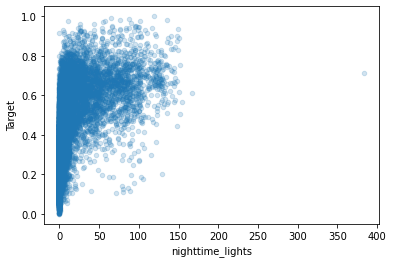

In [8]:
train.plot(x='nighttime_lights', y='Target', kind='scatter', alpha=0.2)

Plotting the relationship nighttime_lights and the wealth index(Target), seems to present a strong positive correlation althought the values are almost sqwashed to zero. Normally the greater the nighttime light, the greater the economic activity therefore a greater wealth index.


In [9]:
#investigating the countries in train and test set
train.country.value_counts()

Nigeria                     2695
Kenya                       2626
Tanzania                    2450
Malawi                      1957
Ethiopia                    1721
Ghana                       1419
Mali                        1295
Cameroon                    1041
Rwanda                       984
Senegal                      903
Mozambique                   879
Lesotho                      794
Sierra Leone                 785
Guinea                       593
Cote d'Ivoire                481
Togo                         330
Swaziland                    270
Central African Republic     231
Name: country, dtype: int64

In [10]:
#same in the test
test.country.value_counts()

Uganda                          1584
Zimbabwe                        1189
Zambia                          1038
Burkina Faso                     997
Angola                           855
Democratic Republic of Congo     785
Benin                            746
Name: country, dtype: int64

* Important finding: The countries in the test set are completely different from the countries in the train set. This kind of scenario will probably affect the test data as far as **generalization** is concern (the model will be unable to generalize well on unseen data).To over come this problem i build a customized train_test_split, which splits my train data , based on the feauture name **country**, i.e the model is trained on a given set of countries and validates on a country with which it hasn't been trained with. By so doing i search for the model with the smallest mean_square_error (the model that generalizes well on unseen data) and use it to do my prediction on the test set.

In [11]:
full = pd.concat([train,test]).reset_index()

In [12]:
full.head()

,index,ID,country,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target
0,0,ID_AAIethGy,Ethiopia,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783
1,1,ID_AAYiaCeL,Ethiopia,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898
2,2,ID_AAdurmKj,Mozambique,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320
3,3,ID_AAgNHles,Malawi,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107
4,4,ID_AAishfND,Guinea,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328


In [13]:
_country = pd.get_dummies(full['country'])

In [14]:
full = pd.concat([full.drop('country',axis=1),_country],axis=1)

In [15]:
_country.head()

,Angola,Benin,Burkina Faso,Cameroon,Central African Republic,Cote d'Ivoire,Democratic Republic of Congo,Ethiopia,Ghana,Guinea,Kenya,Lesotho,Malawi,Mali,Mozambique,Nigeria,Rwanda,Senegal,Sierra Leone,Swaziland,Tanzania,Togo,Uganda,Zambia,Zimbabwe
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
full.head()

,index,ID,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target,Angola,Benin,Burkina Faso,Cameroon,Central African Republic,Cote d'Ivoire,Democratic Republic of Congo,Ethiopia,Ghana,Guinea,Kenya,Lesotho,Malawi,Mali,Mozambique,Nigeria,Rwanda,Senegal,Sierra Leone,Swaziland,Tanzania,Togo,Uganda,Zambia,Zimbabwe
0,0,ID_AAIethGy,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,ID_AAYiaCeL,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,ID_AAdurmKj,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,3,ID_AAgNHles,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,4,ID_AAishfND,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Feature Engineering and data Preprocessing

* Important finding: Trying to categorize continuous variable really improve the model. Despite the fact that i couldn't create indicator function for certain abnormalities(patterns that i think to be abnormal), it is possible to quantify some continuous variable based on ranges of values. 
* Example i created a feature that characterize the population density interms of **small size, medium size, big and very big size** it gives more meaning to the actual values found in the ghsl_pop_density column. 

* I did thesame for the distance to capital, which is also a good indicator of the wealth index.

In [17]:
# the function below takes 
"""input____:
name of data set:data
the column you want to categorize: a
the name of the newly created feature: b
output____:
a newly created column with categorical values, interms of size and base on the percentile of the feature
you want to caategorize"""
def group(data,a,b):
  data[b]='none'
  for i,j in enumerate(data[a]):
    if j>= np.min(data[a]) and j < np.percentile(data[a],25):
      data.loc[i,b]='small'
    elif j>= np.percentile(data[a],25) and j< np.percentile(data[a],50):
      data.loc[i,b]='medium'
    elif j>=np.percentile(data[a],50) and j< np.percentile(data[a],75):
      data.loc[i,b]='big'
    elif j>= np.percentile(data[a],75):
      data.loc[i,b]='very_big'
  return data

In [18]:
#creating categorical variable for the feature dist_to_capital
full=group(full,'dist_to_capital','dist')
#train=group(train,'dist_to_capital','dist')

In [19]:
#creating categorical variable for the population density
full=group(full,'ghsl_pop_density','pop_size')
#train=group(train,'ghsl_pop_density','pop_size')

In [20]:
#creating categorical variable for the population density
full=group(full,'nighttime_lights','night_size')
#train=group(train,'ghsl_pop_density','pop_size')

The two features created below was based on the splitting of my train data, using the customized function built to do so. The minimum error obtain after training my model with each splits (one split containing 17 countries and the last split containing the last country, i did so manually for all the 18 countries in the train set), reveals that, the country **Guinea** has the smallest mean square error, predicting the wealth index using this model will probably have a good generalization perfomance.

In [21]:
#the mean square error for country Kenya is 0.016115087928056746
#the mean square error for country Nigeria is 0.04404187886936057
#the mean square error for country Tanzania is 0.012639512026332969
#the mean square error for country Malawi is 0.01059467702900494
#the mean square error for country Ethiopia is 0.00926243755596883
#the mean square error for country Ghana is 0.019099523614234493
#the mean square error for country Mali is 0.010061246293276543
#the mean square error for country Cameroon is 0.009041880250884263
#the mean square error for country Rwanda is 0.00968488508539336
#the mean square error for country Senegal is 0.02888667326733214
#the mean square error for country Mozambique is 0.015774485558534893
#the mean square error for country Lesotho is 0.015923862512533117
#the mean square error for country Sierra Leone is 0.011198435721676813
#the mean square error for country Guinea is 0.008128704740007606
#the mean square error for country Cote d'Ivoire is 0.03506951538358788
#the mean square error for country Togo is 0.018535950450297024
#the mean square error for country Swaziland is 0.05061226689827493
#the mean square error for country Central African Republic is 0.0365024889587078

In [22]:
#I Created this feature based on the distribution of the country Guinea, i wanted the dataset to have 
# a kind of similar distribution with that of guinea the reason been that if Guinea reveals the smallest
#mean square error, then if my train data looks similar to it, the overall mean square error will also decrease
# and it actually decreased.
full["capital_n"]=0
#test["capital_n"]=0
def create_features(data):
    for i,j in enumerate(data["dist_to_capital"]):
        if j<1.038623: # this value is the smallest distance to capital of Guinea
            data.loc[i,"capital_n"]=1
    return data

In [23]:
#full['lands']=full['ghsl_built_pre_1975']+full['ghsl_built_1975_to_1990']+full['ghsl_built_1990_to_2000']+full['ghsl_built_2000_to_2014']

Looking at the **Corpernicus** global landcover with water layers,(and also from some research papers) i realised that regions with permanent land water and temporal land water turn to have good yiels of crops production(that will surely lead to a good wealth index). But in an attempt to bring out a relationship between **landcover_crop_fraction** and **landcover_water_permanent/seasonal**, the error increased tremendously. So i decided to limit my self on creating **seasonality** indicator for the landcover water seasonal feature. Clusters with landcover water seasonal=0, are probably in the dry season, and regions with seasonal water different from 0 are surely in the rainy seasons. The later have more access to water and will probably have good crop yields.

Again this feature improved my position on the leaderboard

In [24]:
#Creating seasonality feature
full["seasons"]=0
#test["seasons"]=0
def seasonality(data):
    for i,j in enumerate(data["landcover_water_seasonal_10km_fraction"]):
        if j==0:
          data.loc[i,"seasons"]=1 #dry seasons areas
    return data

*  Next, i looked around checking the population global settlement, built-up lands before 1975 to 2014 (ghsl_pre_1975 to ghsl_2000_to_2014). Normaly the proportion of land not built up is equal to $1-total ~~proportion~~of~~land~~built$. But again there were some abnormalities in the data

In [25]:
# summing all the proportion of lands (built and not built), should give us one normally
#train['check_proportion']=train['ghsl_built_pre_1975']+train['ghsl_built_1975_to_1990']+train['ghsl_built_1990_to_2000']+train['ghsl_built_2000_to_2014']+train['ghsl_not_built_up']
#len(train[train.check_proportion!=1])

We have exactly **12975** clusters presenting that abnormality, again i created an indicator variable for that, and it really reduced the error on the leaderboard

In [26]:
#Checking for proportionality in distribution of land built layers
full["abnormal_built_proportion"]=0
#test["abnormal_built_proportion"]=0
def abnormal_built(data):
  for i,j in enumerate(data):
    if data.loc[i,'ghsl_not_built_up']+data.loc[i,'ghsl_built_pre_1975']+data.loc[i,'ghsl_built_2000_to_2014']+data.loc[i,'ghsl_built_1990_to_2000']+data.loc[i,'ghsl_built_1975_to_1990']!=1:
      data.loc[i,'abnormal_built_proportion']=1
  return data

In [27]:
#create a variable for the year 2012 and 1999 according to the distribution of Guinea
full["year_n"]=0
#test["year_n"]=0
def year(data):
    for i,j in enumerate(data["year"]):
        if j==2012 or j==1999: # this are the two different years for which informations for the clusters in Guinea were collected
            data.loc[i,"year_n"]=1
    return data

Again, using the corpenicus global landcover layers we realize whenever there is global settlement, the ratio of previous/impervious land increases with time (pervious lands could be urban areas and impervious could be rural urban), meaning that the proportion urban areas could probably increase as time goes on.

* With this finding i classified the lands based on their **built_year** if a land is built below year 2000, the land is probably impervious (at this period) and from year 2000 and above the land becomes more and more pervious

This finding slightly reduce the error in the leaderboard.

In [28]:
full['built_year']=0
#test['built_year']=0
def building_year(data):
  for i,j in enumerate(data["year"]):
    if j<2000:
      data.loc[i,'built_year']=1
  return data

* The nighttime_light: I started by checking if there exist some clusters where there could be nighttime light intensity, without a **human settlement(population density)** or again human settlement without any nighttime light. The reason throught this is because, if there is human settlement in a given region, there should surely be a little amount of nighttime economic activities, and also regions with no human settlements are likely not to have economic nighttime economic activities(they could be forest,mountains...)

In [29]:
#checking existence of regions of nighttime light with no human settlement and vice-versa
len(train[((train.ghsl_pop_density ==0)&(train.nighttime_lights!=0))|((train.ghsl_pop_density !=0)&(train.nighttime_lights==0))])

8893

* There exist around **8893** clusters, fufilling the condition above, so we start by creating an empty column named **abnormal_light** and fill them with zeros, then the clusters(index) which fullfill the condition, we replace the zero by one. This newly created feature turned to reduce the error in the public leader board.

In [30]:
#creating the function for abnormal nighttime light intensity
full["abnormal_light"]=0
#test['abnormal_light']=0
def abnormal_light(data):
    for i,j in enumerate(data[((data.ghsl_pop_density ==0)&(data.nighttime_lights!=0))|((data.ghsl_pop_density !=0)&(data.nighttime_lights==0))]):
        data.loc[i,"abnormal_light"]=1
    return data

In [31]:
#people with no water access nor light are probably poor
full["poor"]=0
def poor(data):
  for i,j in enumerate(data[(data.nighttime_lights==0)&(data.landcover_water_permanent_10km_fraction==0)]):
    data.loc[i,"poor"]=1
  return data

In [32]:
#code water access
full['water_access']=full['landcover_water_seasonal_10km_fraction']+full['landcover_water_permanent_10km_fraction']+full['ghsl_water_surface']

In [33]:
#feauture for guinea distribution
full=create_features(full)
#test=create_features(test)
# feature for the year of collection of 
#information for Guinea
full=year(full)
#test=year(test)
# Fitting the abnormal light feature
full=abnormal_light(full)
#test=abnormal_light(test)
##features about the abnormally built up lands
full=abnormal_built(full)
#test=abnormal_built(test)
#features about pervious/impervious lands
full=building_year(full)
#test=building_year(test)
#features about water seasonality
full=seasonality(full)
#test=seasonality(test)
full=poor(full)

In [34]:
# Slicing the Values back
train= full[:train.shape[0]]

test= full[train.shape[0]:]

In [35]:
train.head()

,index,ID,year,urban_or_rural,ghsl_water_surface,ghsl_built_pre_1975,ghsl_built_1975_to_1990,ghsl_built_1990_to_2000,ghsl_built_2000_to_2014,ghsl_not_built_up,ghsl_pop_density,landcover_crops_fraction,landcover_urban_fraction,landcover_water_permanent_10km_fraction,landcover_water_seasonal_10km_fraction,nighttime_lights,dist_to_capital,dist_to_shoreline,Target,Angola,Benin,Burkina Faso,Cameroon,Central African Republic,Cote d'Ivoire,Democratic Republic of Congo,Ethiopia,Ghana,Guinea,Kenya,Lesotho,Malawi,Mali,Mozambique,Nigeria,Rwanda,Senegal,Sierra Leone,Swaziland,Tanzania,Togo,Uganda,Zambia,Zimbabwe,dist,pop_size,night_size,capital_n,seasons,abnormal_built_proportion,year_n,built_year,abnormal_light,poor,water_access
0,0,ID_AAIethGy,2016,R,0.0,0.000000,0.000000,0.000055,0.000536,0.999408,12.146134,25.489659,0.879484,0.000000,0.000000,0.000000,278.788451,769.338378,0.132783,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,big,medium,medium,0,1,1,0,0,1,1,0.000000
1,1,ID_AAYiaCeL,2005,R,0.0,0.000000,0.000110,0.000000,0.000018,0.999872,113.806716,64.136053,0.601427,0.000000,0.005427,0.000000,200.986978,337.135243,0.004898,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,medium,very_big,medium,0,0,0,0,0,1,1,0.005427
2,2,ID_AAdurmKj,2009,R,0.0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,4.400096,0.131900,0.000000,0.003078,0.000000,642.594208,169.913773,0.097320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,very_big,small,medium,0,0,0,0,0,1,1,0.003078
3,3,ID_AAgNHles,2015,R,0.0,0.000141,0.000181,0.000254,0.000228,0.999195,5.213320,25.379371,2.017136,11.293841,0.131035,0.000000,365.349451,613.591610,0.304107,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,big,medium,medium,0,0,1,0,0,1,1,11.424876
4,4,ID_AAishfND,2012,U,0.0,0.011649,0.017560,0.017383,0.099875,0.853533,31.734661,5.081620,22.815984,0.005047,0.130475,1.461894,222.867189,192.926363,0.605328,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,medium,big,big,0,0,1,1,0,1,1,0.135523


In [36]:
"""The function below splits my train data, into 17 countries for training
and 1 country for validation.
input___: The name of the country with which the split will be done
output___: 4 variables representing our split interms
of the portion of training and validation(like the train_test_split)"""
def split(a):
    data=train[train.Guinea!=a]
    x_train=data.drop("Target",axis=1)
    y_train=data["Target"]
    data_2=train[train.Guinea==a]
    x_val=data_2.drop("Target",axis=1)
    y_val=data_2["Target"]
    return x_train,x_val,y_train,y_val

In [37]:
a=1
x_train,x_val,y_train,y_val=split(a)

Important: after splitting our train data, we decided to drop the column country, because it was of know used after.

### Data Preprocessing
* The numerical variables were simply normalized using min max scaling
* The urban_or_rural variable was label encode (since it only contains 2 categories)

* Our newly created features (from the group function) were one_hot encoded

all this preprocessing was done using the preprocessed function below.

In [38]:
# creating our label encoder object
le=LabelEncoder()
del test['Target']

In [39]:
#we define a simple function to preprocess our data
def preprocess(data):
    data=data.drop(["ID",'index','Guinea','Cameroon','Nigeria','Kenya'],axis=1)
    categ=['dist','pop_size','night_size']
    #trying with one hot encoding of the country variable
    #data=pd.get_dummies(data,prefix_sep="_",columns=["country"])
    data["urban_or_rural"]=le.fit_transform(data["urban_or_rural"])
    #data["light_size"]=le.fit_transform(data["light_size"])
    data = pd.get_dummies(data, prefix_sep="_", columns=categ)
    scaler=MinMaxScaler(feature_range=(0,1))# we normalize the variables into values between (0 and 1)
    data=scaler.fit_transform(data)
    return data

In [40]:
#preprocessing our data as well as the test data (test_prp)
x_train=preprocess(x_train)
x_val=preprocess(x_val)
test_prp=preprocess(test)

# Now we can build our model

* Catboost reveals to perform very well
* I tried neural network but didn't perform better than catboost

In [41]:
#!pip install catboost

In [42]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [43]:
#model3
model_2=LGBMRegressor(max_depth=3,thread_count=8,n_estimators=100)#      learning_rate=0.2
model_2.fit(x_train,y_train)
model_2.score(x_val,y_val)

0.8103102628370997

In [44]:
#!pip install lightgbm

In [45]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

In [46]:
#for max_depth in [3, 5, 8, 10, 14, 18]:
#    model = CatBoostRegressor(max_depth=max_depth)
    # Again, you van use a better method to evaluate the model here...
#    model.fit(x_train, y_train)
#    print(max_depth, mean_squared_error(y_val, model.predict(x_val)))

No parameter tunning was done. This is because the train set distribution is different from the test set distribution. As a result the cross validation score obtain in the train data will be different on the test data(leader board score), so i decided to rely on my cross validation based on countries, i followed my instinct :) 

In [47]:
#model3
model_3=CatBoostRegressor(max_depth=3,thread_count=8,n_estimators=100,verbose=True)    #      learning_rate=0.2
model_3.fit(x_train,y_train)
model_3.score(x_val,y_val)

Learning rate set to 0.385694
0:	learn: 0.1529742	total: 61.9ms	remaining: 6.12s
1:	learn: 0.1338806	total: 78.2ms	remaining: 3.83s
2:	learn: 0.1240814	total: 87.8ms	remaining: 2.84s
3:	learn: 0.1173550	total: 100ms	remaining: 2.4s
4:	learn: 0.1118970	total: 113ms	remaining: 2.15s
5:	learn: 0.1088151	total: 122ms	remaining: 1.91s
6:	learn: 0.1067036	total: 132ms	remaining: 1.75s
7:	learn: 0.1048678	total: 144ms	remaining: 1.66s
8:	learn: 0.1032808	total: 161ms	remaining: 1.63s
9:	learn: 0.1021668	total: 174ms	remaining: 1.57s
10:	learn: 0.1010805	total: 200ms	remaining: 1.61s
11:	learn: 0.1001766	total: 209ms	remaining: 1.54s
12:	learn: 0.0996635	total: 227ms	remaining: 1.52s
13:	learn: 0.0991929	total: 231ms	remaining: 1.42s
14:	learn: 0.0985998	total: 247ms	remaining: 1.4s
15:	learn: 0.0981941	total: 263ms	remaining: 1.38s
16:	learn: 0.0978404	total: 284ms	remaining: 1.39s
17:	learn: 0.0973445	total: 305ms	remaining: 1.39s
18:	learn: 0.0970414	total: 320ms	remaining: 1.36s
19:	learn:

0.7605156684221945

In [48]:
#from sklearn.model_selection import train_test_split
#from xgboost import XGBRegressor
#x_train,x_val,y_train,y_val=train_test_split(train_prp,y,test_size=0.1,random_state=42)

In [49]:
#using the mean_squared error as metric
from sklearn.metrics import mean_squared_error
print("the mean square error for country {} is {}".format(a,mean_squared_error(y_val,model_3.predict(x_val))))

the mean square error for country 1 is 0.00824091239835235


In [50]:
#creating our submission file
submit["Target"]=model_3.predict(test_prp)

In [51]:
submit.head()

,ID,Target
0,ID_AAcismbB,0.089644
1,ID_AAeBMsji,0.215986
2,ID_AAjFMjzy,0.628663
3,ID_AAmMOEEC,0.391997
4,ID_ABguzDxp,0.236327


In [52]:
submit.to_csv("baseline.csv",index=False)